In [1]:
### Generic imports 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats

### ML imports
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import callbacks, regularizers
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from livelossplot.keras import PlotLossesCallback

### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Plot setup
plt.rcParams.update({
    'figure.dpi': 150,
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.size": 15,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

2021-10-19 16:52:42.518579: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Note: To type Greek letters for variables, type e.g. "\alpha" and then hit TAB.

### Load data & preprocess

In [2]:
file = "/data0/mpettee/gaia_data/mock_streams/gaiamock_ra156.2_dec57.5_stream_feh-1.6_v3_100.npy"
df = pd.DataFrame(np.load(file)[:,:6], columns=['μ_δ','μ_α','δ','α','g','b'])
df['stream'] = np.load(file)[:,10]/100
df['stream'] = df['stream'].astype(bool)

# ### Create b-r & g columns; rename others
# df["b-r"] = df.b - df.r
# df.drop(columns = ['b','r'], inplace=True)

### Drop any rows containing a NaN value
df.dropna(inplace = True)

### Restrict data to a radius of 15
center_α = 0.5*(df.α.min()+df.α.max())
center_δ = 0.5*(df.δ.min()+df.δ.max())
df = df[np.sqrt((df.δ-center_δ)**2+(df.α-center_α)**2) < 15]

### Construct GD1 DataFrame
stream = df[df.stream == True]

### Optional: Reduce the background to make the problem easier.

In [3]:
n_sig = len(df[df.stream == True])
n_bkg = len(df[df.stream == False])
print("Before reduction, stream stars make up {:.3f}% of the dataset.".format(100*n_sig/len(df)))

Before reduction, stream stars make up 0.032% of the dataset.


In [4]:
fraction = 0.9
events_to_drop = np.random.choice(df[df.stream == False].index, int(fraction*n_bkg), replace=False)
df = df.drop(events_to_drop)
print("After reduction, stream stars make up {:.3f}% of the dataset.".format(100*n_sig/len(df)))

After reduction, stream stars make up 0.321% of the dataset.


### Visualize the data

First, a plot in angular spatial coordinates, highlighting GD1:

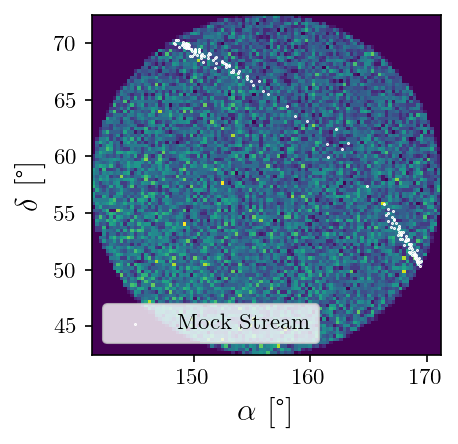

In [5]:
plt.figure(figsize=(3,3)) 
plt.hist2d(df.α,df.δ,bins=100)
plt.scatter(stream.α,stream.δ,color='white',s=0.2, label="Mock Stream")
plt.xlabel(r"$\alpha$ [\textdegree]")
plt.ylabel(r"$\delta$ [\textdegree]")
plt.legend();

Next, the angular velocities for the background:

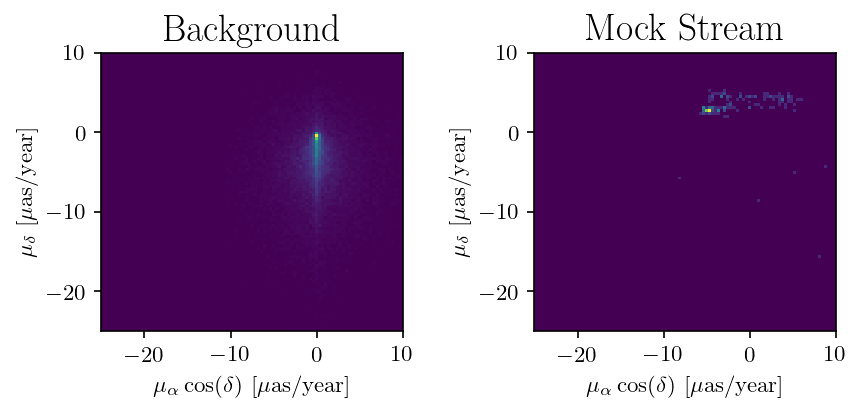

In [6]:
bins = np.linspace(-25,10,100)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3), tight_layout=True)

ax = axs[0]
ax.hist2d(df.μ_α*np.cos(df.δ),df.μ_δ, bins=[bins,bins])
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
ax.set_title("Background")

ax = axs[1]
ax.hist2d(stream.μ_α*np.cos(stream.δ),stream.μ_δ, bins=[bins,bins])
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
ax.set_title("Mock Stream");

### Define the signal & sideband regions

We want to pick a variable that is relatively localized for the mock stream. Comparing these two angular velocities, it's clear that we should pick $\mu_\delta$, as its distribution is narrower:

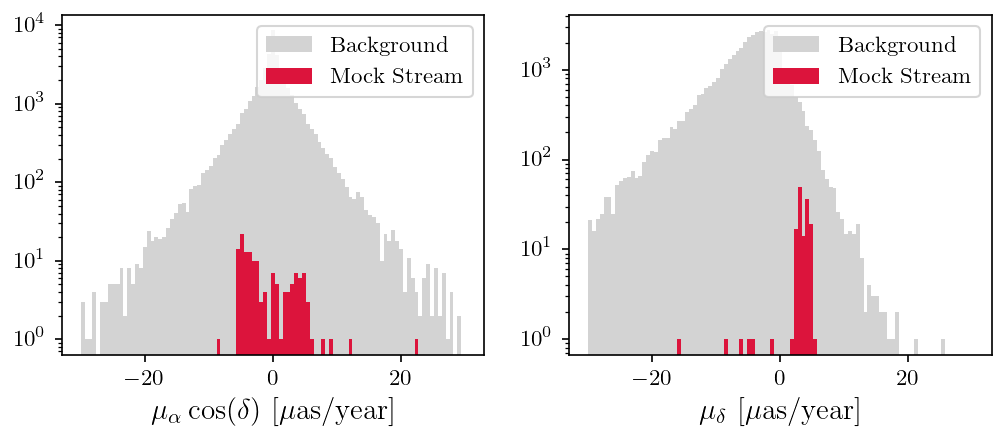

In [7]:
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
ax = axs[0]
ax.hist(df.μ_α*np.cos(df.δ), bins = np.linspace(-30,30,100), color="lightgray", label="Background")
ax.hist(stream.μ_α*np.cos(stream.δ), bins = np.linspace(-30,30,100), color="crimson", label="Mock Stream")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=14)

ax = axs[1]
ax.hist(df.μ_δ, bins = np.linspace(-30,30,100), color="lightgray", label="Background")
ax.hist(stream.μ_δ, bins = np.linspace(-30,30,100), color="crimson", label="Mock Stream")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=14);

Now we'll define the signal & sideband regions for this variable:

/tmp/ipykernel_32543/2921757330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > 3) & (df_slice.μ_δ < 4.5)), 1, 0)


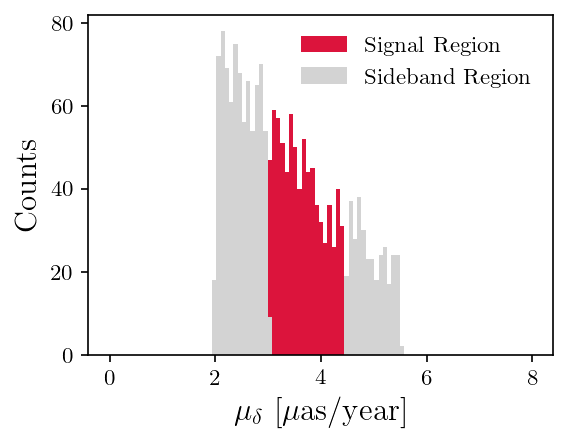

In [8]:
df_slice = df[(df.μ_δ > 2) & (df.μ_δ < 5.5)]
df_slice['label'] = np.where(((df_slice.μ_δ > 3) & (df_slice.μ_δ < 4.5)), 1, 0)

plt.figure(figsize=(4,3))
bins = np.linspace(0,8,100)
plt.hist(df_slice[df_slice.label == 1].μ_δ,bins=bins,color="crimson",label="Signal Region")
plt.hist(df_slice[df_slice.label == 0].μ_δ,bins=bins,color="lightgray",label="Sideband Region")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("Counts");

### Prepare datasets for training

In [10]:
training_vars = ['α','δ','μ_α','b','g'] 

# 70/15/15 train/validate/test split
train, validate, test = np.split(df_slice.sample(frac=1), [int(.7*len(df_slice)), int(.85*len(df_slice))])

x_train, x_val, x_test = [train[training_vars], validate[training_vars], test[training_vars]]
y_train, y_val, y_test = [train.label, validate.label, test.label]

# pre-processing by official method:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

### Train CWoLa model

In [11]:
model = Sequential()
layer_size = 32
dropout = 0.2
l2_reg = 1e-2
model.add(Dense(layer_size, input_dim=len(training_vars), activation='relu',
#                activity_regularizer=regularizers.l2(l2_reg)
               )) 
model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
#                activity_regularizer=regularizers.l2(l2_reg)
               ))
model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
#                activity_regularizer=regularizers.l2(l2_reg)
               ))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

2021-10-19 16:54:48.132791: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 16:54:48.133886: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 16:54:48.173629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-10-19 16:54:48.173678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-19 16:54:48.175588: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-19 16:54:48.175639: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                192       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

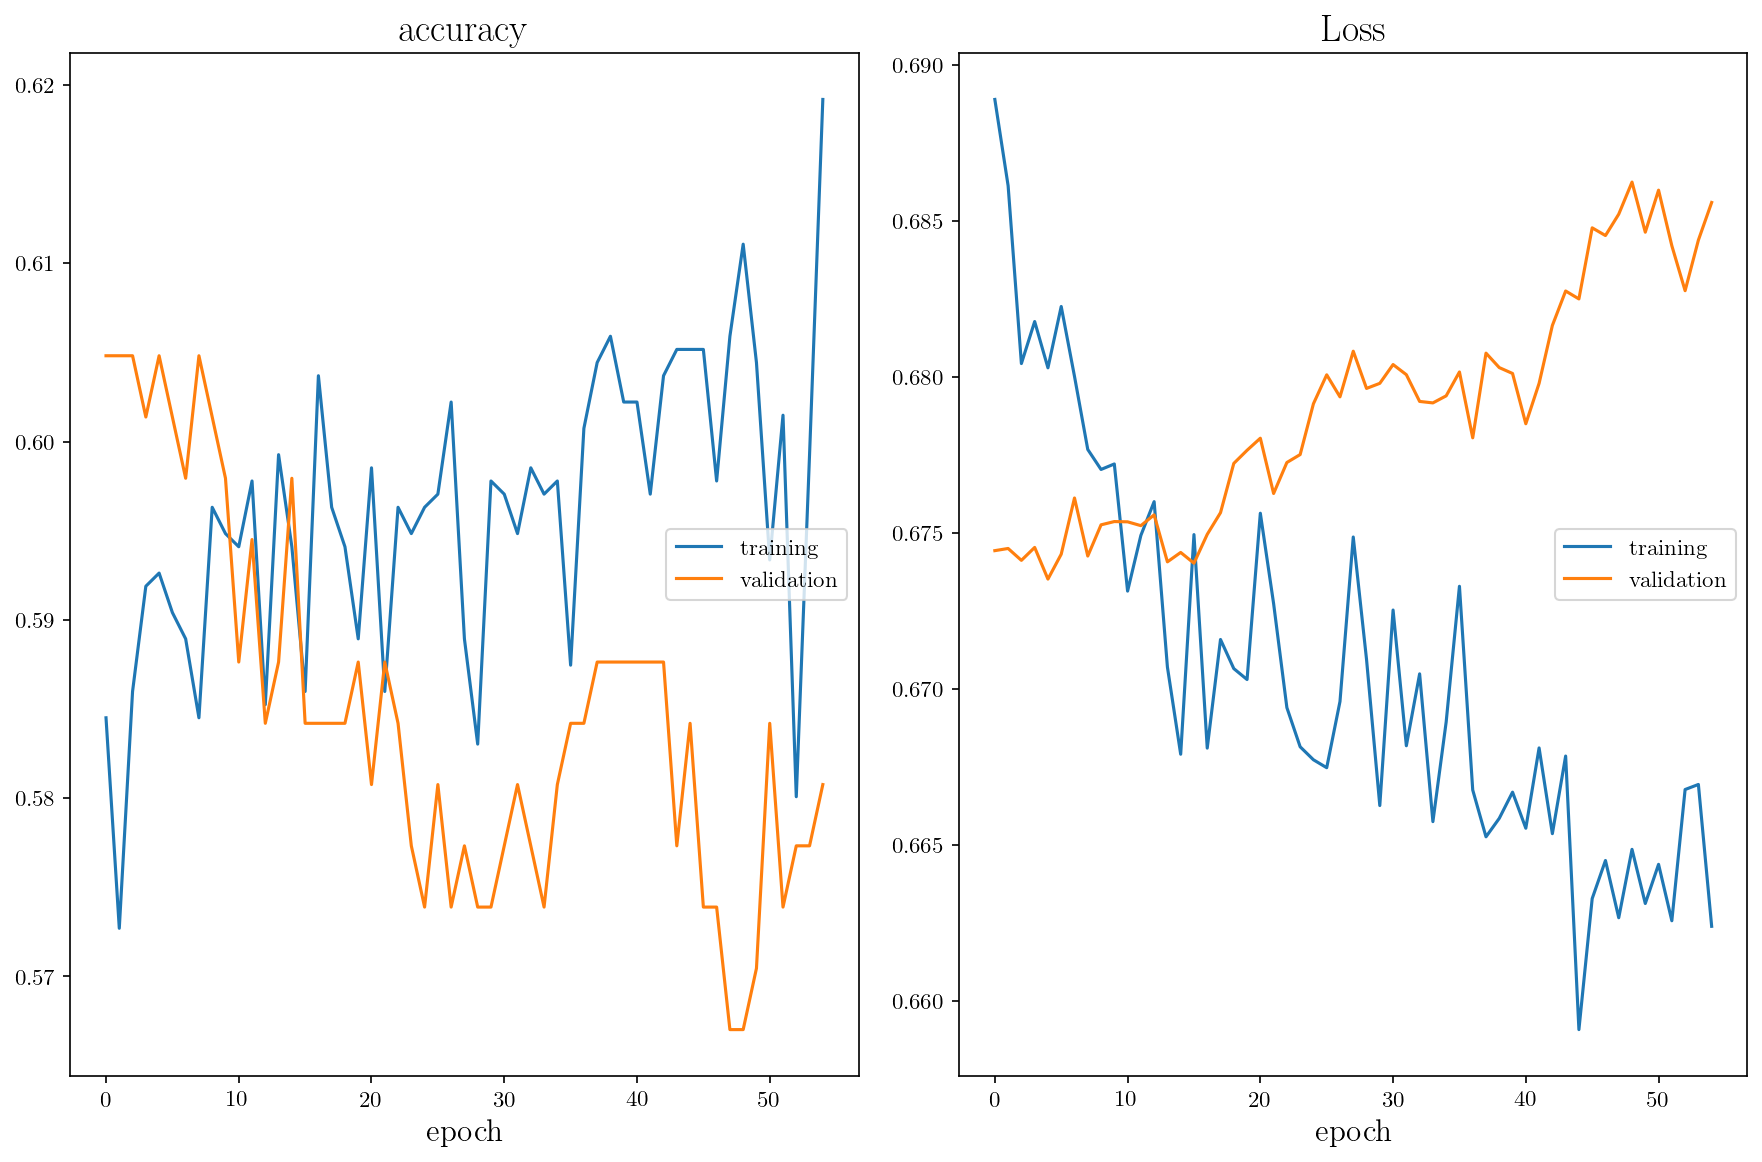

accuracy
	training         	 (min:    0.573, max:    0.619, cur:    0.619)
	validation       	 (min:    0.567, max:    0.605, cur:    0.581)
Loss
	training         	 (min:    0.659, max:    0.689, cur:    0.662)
	validation       	 (min:    0.674, max:    0.686, cur:    0.686)

Epoch 00055: val_loss did not improve from 0.67351
Epoch 00055: early stopping


In [12]:
# stops if val_loss doesn't improve for [patience] straight epochs
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=50, 
                                         verbose=1) 

# saves weights from the epoch with lowest val_loss 
checkpoint = callbacks.ModelCheckpoint("best_weights_mock_stream.h5", 
                                       monitor='val_loss', 
                                       mode='auto', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       save_weights_only=True)

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=32,
                    validation_data=(x_val,y_val),
                    callbacks = [PlotLossesCallback(),
                                checkpoint, 
                                early_stopping]
                   )

In [16]:
# Load the checkpointed model
model.load_weights("best_weights_mock_stream.h5")

### Add the NN prediction score to the test set: 
test["nn_score"] = model.predict(x_test)
fake_eff_baseline, real_eff_baseline, thresholds = roc_curve(np.asarray(y_test), test.nn_score)
auc_baseline = auc(fake_eff_baseline, real_eff_baseline)
print("AUC: {}".format(auc_baseline))

# ### Plot scores:
# fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
# bins=np.linspace(0,1,20)

# ax.tick_params(labelsize=16)
# ax.hist(test[test.label == 1].nn_score, bins=bins, histtype='step', linewidth=2, color="deeppink", label="Signal")
# ax.hist(test[test.label == 0].nn_score, bins=bins, histtype='step', linewidth=2, color="grey", label="Background")
# ax.legend(fontsize=16)
# ax.set_xlim(0, 1)
# ax.set_title("Test Set (15\% of full dataset)")
# ax.set_xlabel("NN Score", size=16)
# ax.set_ylabel("Events", size=16)

AUC: 0.5165019762845849


### Make plot of highest-ranked stars

Plot top $x\%$ of stars by NN score:

In [39]:
x = 10 # desired percentage
top_stars = test[(test['nn_score'] >= test['nn_score'].quantile((100-x)/100))]

Or, just plot the top $N$ stars:

In [40]:
N = 100
top_stars = test.sort_values(by=["nn_score"],ascending=False)[:N]

How much do these stars overlap with the true stream stars?

- **Efficiency** = what percent of stream stars were identified by the NN?
- **Purity** = what percentage of the top stars identified are actually stream stars? 

In [41]:
n_perfect_matches = top_stars.stream.value_counts()[True]
stream_stars_in_test_set = test[test.stream == True]

print("Efficiency: {:.1f}%".format(100*n_perfect_matches/len(stream_stars_in_test_set)))
print("Purity: {:.1f}%".format(n_perfect_matches/len(top_stars)*100))

Efficiency: 39.1%
Purity: 9.0%


Text(0, 0.5, '$\\delta$ [\\textdegree]')

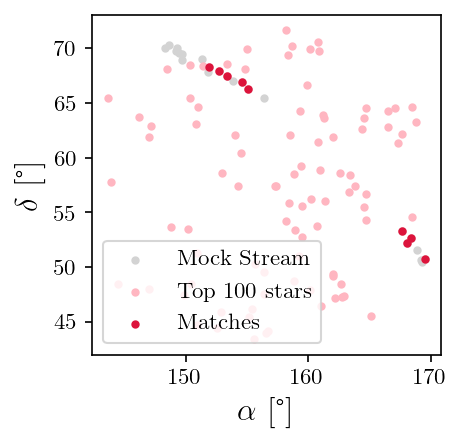

In [43]:
plt.figure(figsize=(3,3)) 
plt.scatter(stream_stars_in_test_set.α, stream_stars_in_test_set.δ, marker='.', 
            # s = 1.0, 
#             alpha = 0.5,
            color = "lightgray",
            label='Mock Stream')
plt.scatter(top_stars.α, top_stars.δ, marker='.', 
            # s = 1.0,
#             alpha = 0.5,
            color = "lightpink",
            label = 'Top {} stars'.format(N))
#             label='Top {:.1f}\% NN Scores'.format(x))
plt.scatter(top_stars[top_stars.stream].α, top_stars[top_stars.stream].δ, marker='.', 
            # s = 1.0,
#             alpha = 0.5,
            color = "crimson",
            label='Matches')
plt.legend()
plt.xlabel(r"$\alpha$ [\textdegree]")
plt.ylabel(r"$\delta$ [\textdegree]")

Maximum purity of 12.9% at 10.7%


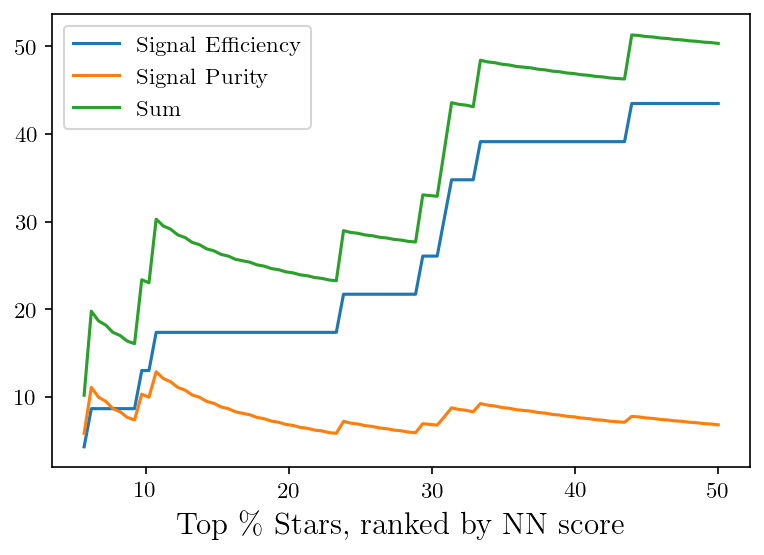

In [44]:
# Scan for optimal percentage
cuts = np.linspace(0.1, 50, 100)
efficiencies = []
purities = []
for x in cuts:
    top_stars = test[(test['nn_score'] >= test['nn_score'].quantile((100-x)/100))]
    if True in top_stars.stream.unique():
        n_perfect_matches = top_stars.stream.value_counts()[True]
        stream_stars_in_test_set = test[test.stream == True]
        efficiencies.append(100*n_perfect_matches/len(stream_stars_in_test_set))
        purities.append(n_perfect_matches/len(top_stars)*100)
    else:
        efficiencies.append(np.nan)
        purities.append(np.nan)

sum = np.array(efficiencies)+np.array(purities)
print("Maximum purity of {:.1f}% at {:.1f}%".format(np.nanmax(purities),cuts[np.nanargmax(purities)]))
plt.plot(cuts, efficiencies, label="Signal Efficiency")
plt.plot(cuts, purities, label="Signal Purity")
plt.plot(cuts, sum, label="Sum")
plt.xlabel("Top \% Stars, ranked by NN score")
plt.legend()